## Import Modules

In [2]:
import os
import json
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm
import glob

from PIL import Image
from sklearn.metrics import f1_score

import torch
from torch import nn, optim
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms import transforms

from transformers import (TrOCRProcessor, 
                        VisionEncoderDecoderModel,)

# add parent directory to path so that we can import our python scripts from all subdirectories
cwd_prefix = "/projectnb/sparkgrp/ml-herbarium-grp/summer2023/kabilanm/ml-herbarium/trocr/evaluation-dataset/handwritten-typed-text-classification/"
import sys
sys.path.append(cwd_prefix)

from utils.utils import *

## Initialize TrOCR Model and Processor

In [5]:
# Initialize the model and processor
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

cache_dir = cwd_prefix+"model/"

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-stage1', cache_dir=cache_dir)
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-stage1', cache_dir=cache_dir)

# Freeze TrOCR layers (we will not train the TrOCR model)
for param in model.parameters():
    param.requires_grad = False

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
processor

In [ ]:
model

## Define Classifier (decoder for the TrOCR encoder)

In [6]:
# Define our  (we will train the classifier)
classifier = nn.Sequential(
    
    nn.Conv2d(1, 16, kernel_size=1, stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=1, stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, kernel_size=1, stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(32 * (577 // 8) * (1024 // 8), 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 1)
)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.003)

classifier

Sequential(
  (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (7): ReLU(inplace=True)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=294912, out_features=512, bias=True)
  (11): ReLU(inplace=True)
  (12): Linear(in_features=512, out_features=512, bias=True)
  (13): ReLU(inplace=True)
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=512, out_features=256, bias=True)
  (16): ReLU(inplace=True)
  (17): Linear(in_features=256, out_features=1, bias=True)
)

## Initialize Device

In [7]:
# Move the model to the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load and Split Dataset

> **Note: TrOCRPreprocessor (custom data loader) and TrOCRProcessor (from hugging face transformers) are different classes.**

In [8]:
# Load the entire dataset (since we don't have a train and validation split originally.
# we will generate a split in the next step)
dataset_path = cwd_prefix+"data/all_preprocessed_data/"

# a wrapper for the custom data loader which applies TrOCRProcessor transformations
dataset = TrOCRPreprocessor(dataset_path, processor)  

In [9]:
# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

# Create the DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

train_size, val_size

(357104, 89276)

## Parallelize Model if Multiple GPUs are Available

In [10]:
# If there are multiple GPUs available, wrap the model with nn.DataParallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model, list(range(torch.cuda.device_count())))

model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## Extract Features and Store Tensors

This loop is to extract image representation (using the TrOCR encoder) and store the tensors.
This was performed as part of the training loop. We have stored the TrOCR encoder's output as tensors so that we don't use the encoder in every epoch as it is a time consuming step. The encoding is done once and in the next step we use the stored tensors to train the classifier for multiple epochs.

In [21]:
# num_epochs = 1

# # (this step is one-time as we are not training the TrOCR model)
# for epoch in range(num_epochs):
    
#     with tqdm(enumerate(train_loader), total=math.ceil(train_size/batch_size)) as pbar:
        
#         for batch_idx, (pixel_values, labels) in pbar:
#             pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)
                        
#             # The `encoder_outputs` variable will contain the intermediate output 
#             # of the vision transformer part of the TrOCR model
#             encoder_outputs = model.module.encoder(pixel_values)

#             # This is the image representation
#             image_representation = encoder_outputs.last_hidden_state
#             # print(image_representation.shape)
#             # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 1, 1024, ]
#             torch.save(image_representation.cpu(), f'tensors/train/train_image_representation_{epoch}_{batch_idx}.pt')
#             torch.save(labels.cpu(), f'{cwd_prefix}tensors/train/labels_{epoch}_{batch_idx}.pt')
    
#     with torch.no_grad():
#         with tqdm(enumerate(val_loader), total=math.ceil(val_size/batch_size)) as pbar:

#             for batch_idx, (pixel_values, labels) in pbar:
#                 pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)

#                 # The `encoder_outputs` variable will contain the intermediate output 
#                 # of the vision transformer part of the TrOCR model
#                 encoder_outputs = model.module.encoder(pixel_values)

#                 # This is the image representation
#                 image_representation = encoder_outputs.last_hidden_state
#                 # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]
#                 torch.save(image_representation.cpu(), f'tensors/valid/val_image_representation_{epoch}_{batch_idx}.pt')
#                 torch.save(labels.cpu(), f'{cwd_prefix}tensors/valid/labels_{epoch}_{batch_idx}.pt')

100%|██████████| 2790/2790 [1:15:25<00:00,  1.62s/it]


## TensorBoard Setup

In [11]:
# TensorBoard setup
from torch.utils.tensorboard import SummaryWriter
import torchvision

writer = SummaryWriter(cwd_prefix+"logs/trocr_encoder_w_classifier/") # this will create a folder if there isn't one

dataiter = iter(train_loader)
images, labels = next(dataiter)

images, labels = images.squeeze(1).to(device), labels.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)
writer.add_image("Sample training images", img_grid)


class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input):
        output = self.model(input)
        # Convert the dictionary output to a tuple.
        return tuple(output.values())

# Visualize the classifier we created
writer.add_graph(ModelWrapper(model.encoder), images)

/projectnb/sparkgrp/kabilanm/.conda/envs/trocr_env/lib/python3.9/site-packages/transformers/models/vit/modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/projectnb/sparkgrp/kabilanm/.conda/envs/trocr_env/lib/python3.9/site-packages/transformers/models/vit/modeling_vit.py:175: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


## Load Tensors stored in the previous step (for training and validation)

In [12]:
train_tensor_directory = cwd_prefix+'tensors/train'
train_dataset = TensorDataset(train_tensor_directory)
train_loader_tensor = DataLoader(train_dataset, batch_size=1, shuffle=False)

val_tensor_directory = cwd_prefix+'tensors/valid'
val_dataset = TensorDataset(val_tensor_directory)
val_loader_tensor = DataLoader(val_dataset, batch_size=1, shuffle=False)

## Training Loop

In [ ]:
num_epochs = 20
best_val_loss = float('inf')
counter = 0

patience = 5

classifier = torch.nn.DataParallel(classifier, [0]) # list(range(torch.cuda.device_count()))
classifier = classifier.to(device)

writer = SummaryWriter(cwd_prefix+"logs/trocr_encoder_w_classifier_exp_2/")

# Training loop
classifier.train()
for epoch in range(num_epochs):
    
    val_correct = 0
    train_correct = 0
    
    val_loss = 0
    train_loss = 0
    
    with tqdm(enumerate(train_loader_tensor), total=math.ceil(train_size/batch_size)) as pbar:
        
        for batch_idx, (image_representation, labels) in pbar:
            
            image_representation = image_representation.squeeze(0).unsqueeze(1)
            labels = labels.float().squeeze(0)
            image_representation, labels = image_representation.to(device), labels.to(device)
            
            optimizer.zero_grad()
            # Pass the image features through the classifier
            classifier_output = classifier(image_representation)
            loss = loss_function(classifier_output, labels)
            
            predictions = torch.round(torch.sigmoid(classifier_output))

            train_loss += loss.item()
            train_correct += (predictions == labels).sum().item()

            loss.backward()
            optimizer.step()
    
    
    classifier.eval()
    with torch.no_grad():
        with tqdm(enumerate(val_loader_tensor), total=math.ceil(val_size/batch_size)) as pbar:

            for batch_idx, (image_representation, labels) in pbar:
                
                image_representation = image_representation.squeeze(0).unsqueeze(1)
                labels = labels.float().squeeze(0)
                image_representation, labels = image_representation.to(device), labels.to(device)

                # Pass the image features through the classifier
                classifier_output = classifier(image_representation)
                loss = loss_function(classifier_output, labels)

                predictions = torch.round(torch.sigmoid(classifier_output))

                val_loss += loss.item()
                val_correct += (predictions == labels).sum().item()
    
    # Calculate average loss and accuracy
    train_loss /= train_size
    train_accuracy = train_correct / train_size

    val_loss /= val_size
    val_accuracy = val_correct / val_size
    
    writer.add_scalars("Loss tracking", {"train_loss": train_loss, "val_loss": val_loss}, epoch+1)
    writer.add_scalars("Accuracy tracking", {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}, epoch+1)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], \n'
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \n'
        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} \n'
        )
    
    # Save the best model based on validation loss and early stopping
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the model
        print("Saving model...")
        torch.save(classifier.state_dict(), cwd_prefix+'model/TrOCR_L_enc_feature_extraction_w_classifier_retrained.pth')
    else:
        counter += 1
        # Check if the counter reaches the patience limit
        if counter >= patience:
            print('Early stopping triggered...')
            break

## Load Trained Model (for testing)

In [14]:
test_classifier = classifier

test_classifier.load_state_dict(torch.load("model/TrOCR_L_enc_feature_extraction_w_classifier_retrained.pth"))
test_classifier.to(device)

DataParallel(
  (module): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=294912, out_features=512, bias=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): ReLU(inplace=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=512, out_features=256, bias=True)
    (16): ReLU(inplace=True)
    (17): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Evaluate on Test Set

In [15]:
# Evaluate the best model on the test dataset
test_data_path = cwd_prefix+"data/test_data/"
test_dataset = TrOCRPreprocessor(test_data_path, processor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

test_size = len(test_loader.dataset)

In [17]:
y_pred = []
y_true = []

test_loss = 0
test_correct = 0

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Testing loop
test_classifier.eval()
with torch.no_grad():
    with tqdm(enumerate(test_loader), total=math.ceil(test_size/batch_size)) as pbar:

        for batch_idx, (pixel_values, labels) in pbar:
            pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)

            # The `encoder_outputs` variable will contain the intermediate output 
            # of the vision transformer part of the TrOCR model
            encoder_outputs = model.encoder(pixel_values)

            # This is the image representation
            image_representation = encoder_outputs.last_hidden_state

            # Pass the image features through the classifier
            classifier_output = test_classifier(image_representation.unsqueeze(1))
            loss = loss_function(classifier_output, labels)

            predictions = torch.round(torch.sigmoid(classifier_output)) # .squeeze(1)

            test_loss += loss.item()
            test_correct += (predictions == labels).sum().item()
            
            y_true.extend(labels) # Save Truth
            y_pred.extend(predictions) # Save Prediction


# Compute F1-scores (we need to move the these tensors to CPU to compute F1-scores)
y_true_cpu = [tensor.cpu().detach().numpy() for tensor in y_true]
y_pred_cpu = [tensor.cpu().detach().numpy() for tensor in y_pred]

100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


## Compute Accuracy and F1-Scores

In [19]:
test_accuracy = test_correct/test_size
test_accuracy

0.9705882352941176

In [20]:
test_f1 = f1_score(y_true_cpu, y_pred_cpu)
test_f1

0.9714285714285713

## Exploring the TrOCR model and preprocessor (please ignore)

In [26]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# load image from the IAM dataset
# url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg"
# image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

image = Image.open("data/all_preprocessed_data/typed/FUNSD0000971160-10.jpg").convert("RGB")
# image = Image.open("data/all_preprocessed_data/typed/syntheticfile-9_crops-000152.jpg").convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'ii'

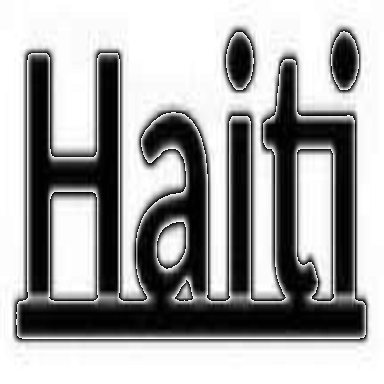

In [21]:
temp_image = transforms.ToPILImage()(pixel_values[0])
temp_image

In [33]:
generated_ids

tensor([[   2, 4132,    2]])

In [11]:
# The `encoder_outputs` variable will contain the intermediate output 
# of the vision transformer part of the TrOCR model
encoder_outputs = model.encoder(pixel_values)

# This is the image representation
image_representation = encoder_outputs.last_hidden_state
image_representation = image_representation.mean(dim=1)  # shape will now be [1, 768]

In [12]:
image_representation

tensor([[ 0.1725, -0.3867, -0.1286,  ...,  0.2052, -0.3625, -0.4994],
        [-0.0924, -0.2957, -0.2853,  ...,  0.6164, -0.2388, -0.2822],
        [ 0.1588, -0.3444, -0.2023,  ...,  0.5765, -0.0988, -0.1870],
        ...,
        [-0.0030, -0.6578,  0.2199,  ...,  0.3897, -0.0497, -0.4029],
        [-0.2889, -0.2004,  0.1602,  ...,  0.5631, -0.2646, -0.0362],
        [ 0.3208, -0.3533,  0.1339,  ...,  0.7275,  0.0027, -0.3574]],
       device='cuda:0')

In [13]:
image_representation.shape

torch.Size([32, 768])